# **Time Series Objective ("CO2 Emission Prediction until the end of 2025")**
## 🎯 Objective:
### In this project, the objective is to predict the evolution of monthly CO₂ emissions until the end of 2025.

## Data Import (SSMS)

In [57]:
import pyodbc
import pandas as pd

# Connexion
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-STG70TI\\SQLSERVER;'
    'DATABASE=DW_SAP_Co2;'
    'Trusted_Connection=yes;'
)

# Requête SQL avec jointures utiles
query = """
SELECT
    F.CO2_Emissions_kg_equipment,
    F.Temperature,
    F.Humidity,
    F.Water_Consumption_PerUnit_L,
    F.Wind_Speed,

    -- Dimensions


    B.brandCode,
    L.Location,
    D.Year,
    D.Month

FROM dbo.Fact_Co2_Emissions F

-- Jointure équipements
LEFT JOIN dbo.Dim_Equipment E ON F.Fk_Equipment = E.Pk_Equipment


-- Jointure autres dimensions
LEFT JOIN dbo.Dim_Brand B ON F.Fk_Brand = B.Pk_brand
LEFT JOIN dbo.Dim_Location L ON F.Fk_Location = L.Pk_Location
LEFT JOIN dbo.Dim_Date D ON F.Fk_Date = D.Pk_Date
"""

df = pd.read_sql(query, conn)
conn.close()


C:\Users\DELL\AppData\Local\Temp\ipykernel_11104\3488305993.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Features

In [6]:
print(df.head())


   CO2_Emissions_kg_equipment  Temperature  Humidity  \
0                  255.881683        21.00      98.0   
1                  255.881683        28.65      27.0   
2                  255.881683        41.60      90.0   
3                  255.881683        19.60      41.0   
4                  255.881683        21.00      98.0   

   Water_Consumption_PerUnit_L  Wind_Speed brandCode Location  Year Month  
0                       1149.0        12.3     BR004   Sousse  2024    02  
1                       1149.0        12.0     BR004    Gabès  2024    02  
2                       1149.0         3.4     BR004     Sfax  2024    02  
3                       1149.0         0.8     BR004    Tunis  2024    02  
4                       1149.0        12.3     BR004   Sousse  2024    02  


# History

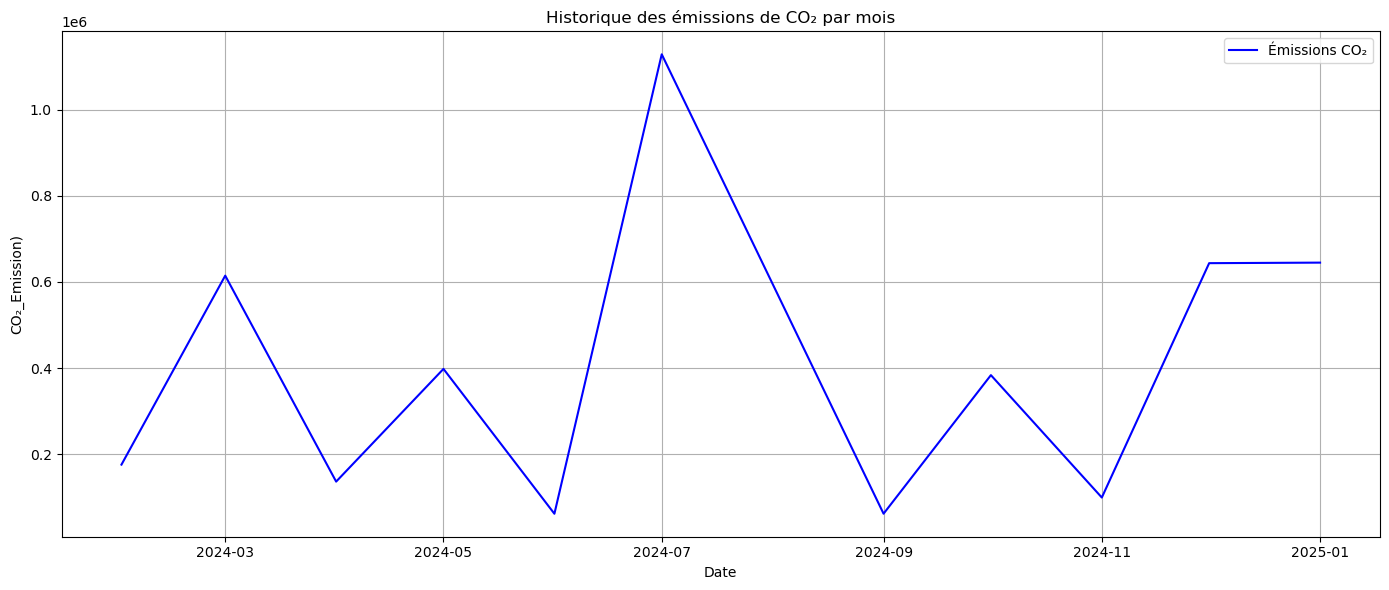

In [58]:
# Nettoyage des noms de colonnes
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Création de la colonne Date
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str))

# Agrégation mensuelle des émissions
df_monthly = df.groupby("Date")["CO2_Emissions_kg_equipment"].sum().reset_index()

# Affichage du graphique
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df_monthly["Date"], df_monthly["CO2_Emissions_kg_equipment"], label="Émissions CO₂", color="blue")
plt.title("Historique des émissions de CO₂ par mois")
plt.xlabel("Date")
plt.ylabel("CO₂_Emission)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **ARIMA Model**
## 📘 Model 1: ARIMA (AutoRegressive Integrated Moving Average)

### The ARIMA model was chosen because it is particularly suited to time series composed of a single variable that changes over time.

Details of the model used
Order chosen: ARIMA(p,d,q):

p (AutoRegression) ➔ dependency on the previous month.

d (Integration) ➔ differencing to make the series stationary.

q (Moving Average) ➔ dependency on past errors.e)


In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Série temporelle propre
ts = df_monthly.set_index("Date")["CO2_Emissions_kg_equipment"]
ts = ts.asfreq('MS')

# ✅ Lissage avec une moyenne mobile sur 3 mois
ts_smoothed = ts.rolling(window=3, min_periods=1).mean()


## Creation and training

In [236]:

# 🔁 Modèle ARIMA 
model = ARIMA(ts_smoothed, order=(9, 0, 6))
model_fit = model.fit()


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



## Prediction

In [237]:
# Nombre de mois à prédire (2025 complet)
forecast_steps = 12

# Générer les prévisions
forecast = model_fit.forecast(steps=forecast_steps)

# Générer l'index temporel correspondant
forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(), periods=forecast_steps, freq='MS')

# Créer une série temporelle des prévisions
forecast_series = pd.Series(forecast, index=forecast_index)



## Metrics

In [238]:

# 4️⃣ Fonctions pour SMAPE et MASE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, train_series):
    naive_forecast = train_series.shift(1).dropna()
    naive_actual = train_series[1:]
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# ⚡ Attention : ici on évalue sur train_ts car pas de vraie valeur de 2025
y_true = ts_smoothed.dropna()
y_pred = model_fit.fittedvalues

# 5️⃣ Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
r2 = r2_score(y_true, y_pred)
smape_value = smape(y_true, y_pred)
mase_value = mase(y_true, y_pred, y_true)

# 6️⃣ 📊 Affichage
print("📈 Métriques ARIMA  :")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f} %")
print(f"SMAPE : {smape_value:.2f} %")
print(f"R²    : {r2:.4f}")
print(f"MASE  : {mase_value:.4f}")


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📈 Métriques ARIMA  :
MAE   : 82425.4192
RMSE  : 96843.0745
MAPE  : 28.19 %
SMAPE : 24.12 %
R²    : 0.5734
MASE  : 0.5482


## ARIMA Display

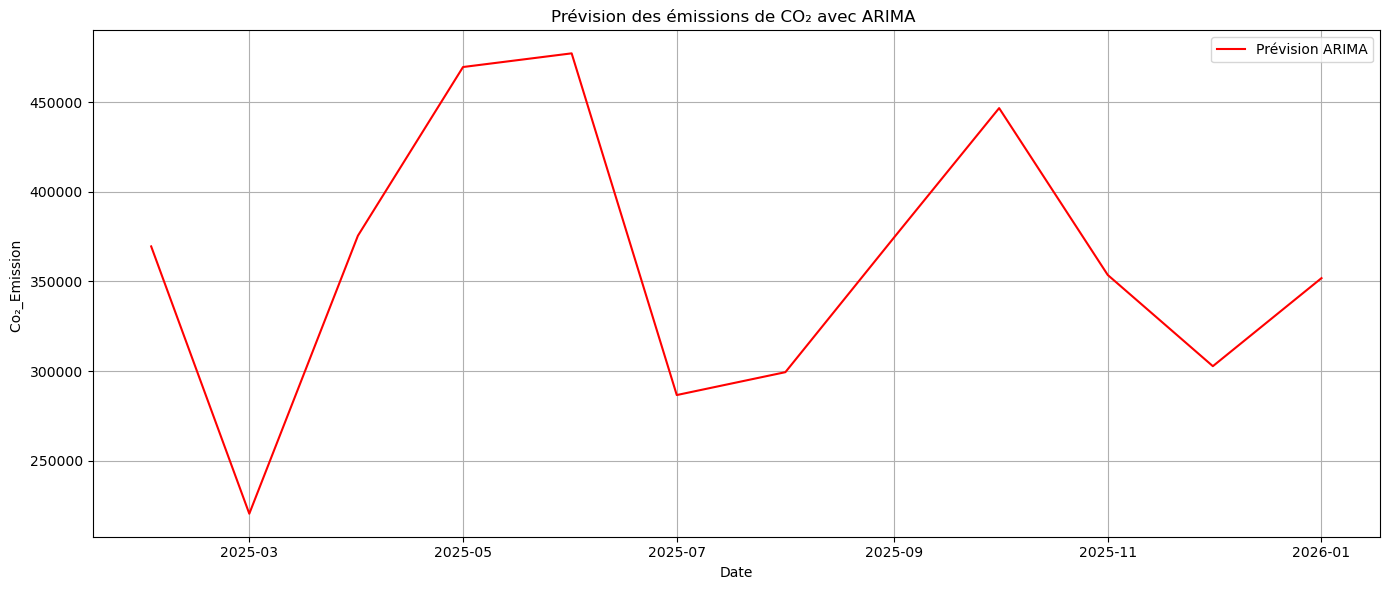

In [239]:

# 📈 Affichage final
plt.figure(figsize=(14, 6))

plt.plot(forecast_series, label="Prévision ARIMA", color="red")
plt.title("Prévision des émissions de CO₂ avec ARIMA ")
plt.xlabel("Date")
plt.ylabel("Co₂_Emission ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 📘 Model 2: SARIMA (Seasonal ARIMA: [AutoRegressive Integrated Moving Average])

### The SARIMA (Seasonal ARIMA) model is an extension of the classic ARIMA model, but with a seasonal component.

Details of the model used
Non-seasonal part (p, d, q)

p: Autoregressive order: Number of lags used (how many previous months are considered).
d: Differencing order: Number of differentiations to make the series stationary.
q: Moving Average order: Number of past errors used to correct the prediction.

Seasonal part (P, D, Q, s)

P: Seasonal autoregressive order: Number of past seasons used (e.g., last winter, last summer, etc.).
D: Seasonal differencing order: Seasonal differentiations (e.g., the current value minus the value 12 months ago).
Q: Seasonal moving average order: Number of seasonal errors used to correct.
s: Seasonal period: Number of periods per cycle (e.g., 12 months in a year).

## Train

In [331]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Séries historiques avec fréquence mensuelle
ts = df_monthly.set_index("Date")["CO2_Emissions_kg_equipment"]
ts = ts.asfreq('MS')
ts_smoothed = ts.rolling(window=3, min_periods=1).mean()

# SARIMA(p,d,q)(P,D,Q,s) — ici saison annuelle = 12 mois
model_sarima = SARIMAX(
    ts_smoothed,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_sarima_fit = model_sarima.fit(disp=False)



WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



## Make the forecast

In [332]:
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # 🔮 Nombre de mois à prédire (1 an)
    forecast_steps = 9
    
    # Prédiction à partir du dernier mois de la série
    sarima_forecast = model_sarima_fit.forecast(steps=forecast_steps)
    
    # Création des dates futures correspondantes
    forecast_index = pd.date_range(start=ts_smoothed.index[-1] + pd.offsets.MonthBegin(), periods=forecast_steps, freq='MS')
    forecast_series = pd.Series(sarima_forecast, index=forecast_index)
    


## Preparing the model

In [333]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# 3️⃣ Jeu de test sur les 6 derniers mois
n_test = 8
train_ts = ts_smoothed[:-n_test]
test_ts = ts_smoothed[-n_test:]

# 🔁 Ré-entraîner SARIMA sur le train uniquement
model_sarima = SARIMAX(
    train_ts,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_sarima_fit = model_sarima.fit(disp=False)

# 🔮 Prédictions sur le test
forecast_sarima_test = model_sarima_fit.forecast(steps=n_test)


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



## Metrics

In [334]:

# 4️⃣ Fonctions pour SMAPE et MASE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, train_series):
    naive_forecast = train_series.shift(1).dropna()
    naive_actual = train_series[1:]
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# 5️⃣ Métriques
mae = mean_absolute_error(test_ts, forecast_sarima_test)
rmse = mean_squared_error(test_ts, forecast_sarima_test, squared=False)
mape = (abs((test_ts - forecast_sarima_test) / test_ts).mean()) * 100
r2 = r2_score(test_ts, forecast_sarima_test)
smape_value = smape(test_ts, forecast_sarima_test)
mase_value = mase(test_ts, forecast_sarima_test, train_ts)

# 6️⃣ 📊 Affichage
print("📈 Métriques SARIMA (sur les 6 derniers mois) :")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f} %")
print(f"SMAPE : {smape_value:.2f} %")
print(f"R²    : {r2:.4f}")
print(f"MASE  : {mase_value:.4f}")


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📈 Métriques SARIMA (sur les 6 derniers mois) :
MAE   : 150383.4517
RMSE  : 165000.4587
MAPE  : 49.15 %
SMAPE : 40.87 %
R²    : -0.0054
MASE  : 1.1887


## SARIMA Display

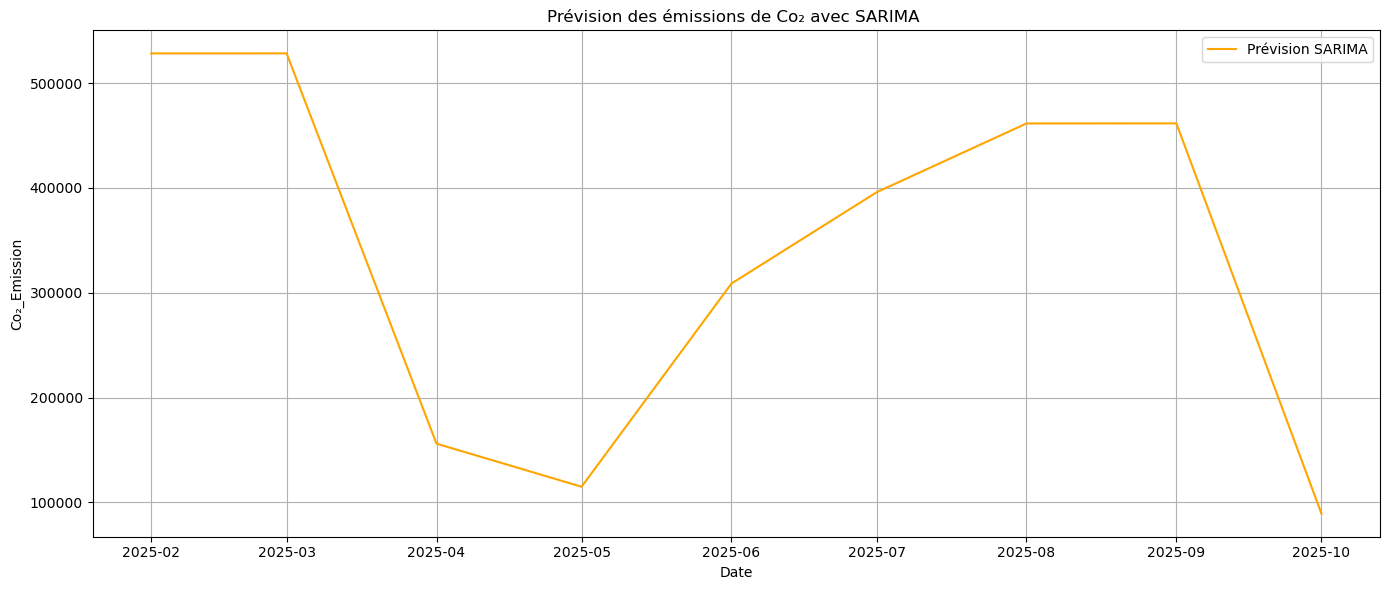

In [335]:
# 📈 
plt.figure(figsize=(14, 6))

plt.plot(forecast_series, label="Prévision SARIMA", color="orange")
plt.title("Prévision des émissions de Co₂ avec SARIMA ")
plt.xlabel("Date")
plt.ylabel("Co₂_Emission")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## 📘 Model 3: Random Forest Regressor Model

### The Random Forest Regressor was chosen to predict CO₂ emissions in time series.
It can effectively capture complex and nonlinear relationships in time series data, such as past trends and recurring behaviors. This model is particularly suitable for non-stationary time series because it does not require the series to be transformed before use. It provides robust predictions even on complex time series with many fluctuations.

## Features

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 🔁 Features / Target
y = df["CO2_Emissions_kg_equipment"]
X = df[["Temperature", "Humidity", "Water_Consumption_PerUnit_L", "Wind_Speed", "brandCode", "Location", "Year", "Month"]]
X_encoded = pd.get_dummies(X, columns=["brandCode", "Location"], drop_first=True)



## Creation and training

In [147]:
# 📂 Split des données
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



## Prediction 

In [148]:
# 🌲 Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

# 🔮 Prédiction
y_pred = rf_model.predict(X_test)


## Metrics

In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Fonctions supplémentaires pour SMAPE et MASE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, y_train):
    naive_forecast = y_train.shift(1).dropna()
    naive_actual = y_train[1:]
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# 2️⃣ Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100
r2 = r2_score(y_test, y_pred)
smape_value = smape(y_test, y_pred)
mase_value = mase(y_test.reset_index(drop=True), pd.Series(y_pred), y_train.reset_index(drop=True))

# 3️⃣ 📊 Affichage complet
print("📊 Métriques Random Forest Regressor :")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f} %")
print(f"SMAPE : {smape_value:.2f} %")
print(f"R²    : {r2:.4f}")
print(f"MASE  : {mase_value:.4f}")


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Métriques Random Forest Regressor :
MAE   : 109.7889
RMSE  : 152.4148
MAPE  : 21.93 %
SMAPE : 18.96 %
R²    : 0.6096
MASE  : 0.4048


WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\AppData\Local\Temp\ipykernel_11104\3657518393.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



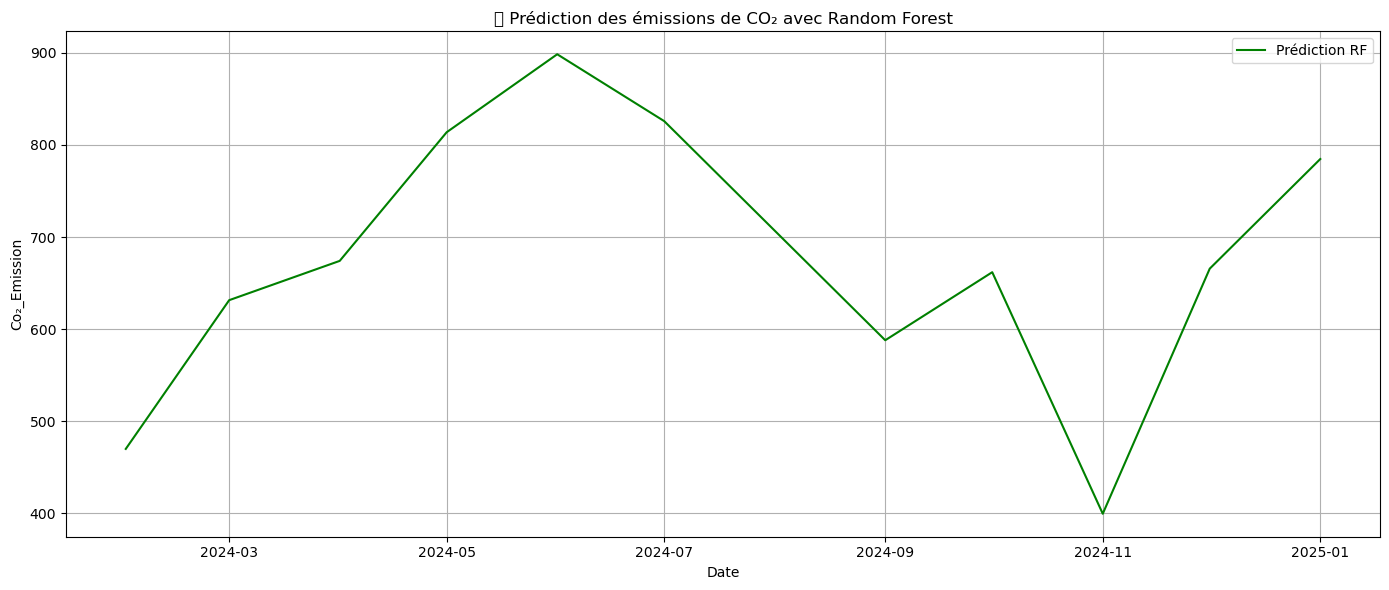

In [151]:
import matplotlib.pyplot as plt

# 📅 Récupérer les dates correspondant aux indices de test
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

# ✅ Regrouper par date (moyenne mensuelle si plusieurs lignes par mois)
df_test_grouped = df_test.groupby("Date")["y_pred"].mean().reset_index()

# 📈 Tracer la courbe
plt.figure(figsize=(14, 6))
plt.plot(df_test_grouped["Date"], df_test_grouped["y_pred"], label="Prédiction RF", color="green")
plt.title("📈 Prédiction des émissions de CO₂ avec Random Forest")
plt.xlabel("Date")
plt.ylabel("Co₂_Emission")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 📘 Model 4: Gradient Boosting Regressor
### The Gradient Boosting Regressor was chosen to predict CO₂ emissions in time series because it is able to capture complex nonlinear relationships in temporal data, including long-term trends and changes. It uses a decision tree aggregation approach to reduce prediction error and improve results. This model is flexible, robust to outliers, and can handle non-stationary series with complex interactions.

## Features

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Features / Target
y = df["CO2_Emissions_kg_equipment"]
X = df[["Temperature", "Humidity", "Water_Consumption_PerUnit_L", "Wind_Speed", "brandCode", "Location", "Year", "Month"]]
X_encoded = pd.get_dummies(X, columns=["brandCode", "Location"], drop_first=True)


## Training and Prediction

In [112]:

# 📂 Split des données
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔥 Modèle Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=300,  # plus d'arbres pour plus de finesse
    learning_rate=0.05,  # learning rate faible pour éviter overfitting
    max_depth=4,  # arbres pas trop profonds
    random_state=42
)
gbr_model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred = gbr_model.predict(X_test)


## Metrics

In [113]:

# 1️⃣ Fonctions SMAPE et MASE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, y_train):
    naive_forecast = y_train.shift(1).dropna()
    naive_actual = y_train[1:]
    mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# 2️⃣ Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100
r2 = r2_score(y_test, y_pred)
smape_value = smape(y_test, y_pred)
mase_value = mase(y_test.reset_index(drop=True), pd.Series(y_pred), y_train.reset_index(drop=True))

# 3️⃣ 📊 Affichage des métriques
print("📊 Métriques Gradient Boosting Regressor :")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape:.2f} %")
print(f"SMAPE : {smape_value:.2f} %")
print(f"R²    : {r2:.4f}")
print(f"MASE  : {mase_value:.4f}")


📊 Métriques Gradient Boosting Regressor :
MAE   : 55.7061
RMSE  : 100.4897
MAPE  : 8.94 %
SMAPE : 8.30 %
R²    : 0.8303
MASE  : 0.2054


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# GBR Display

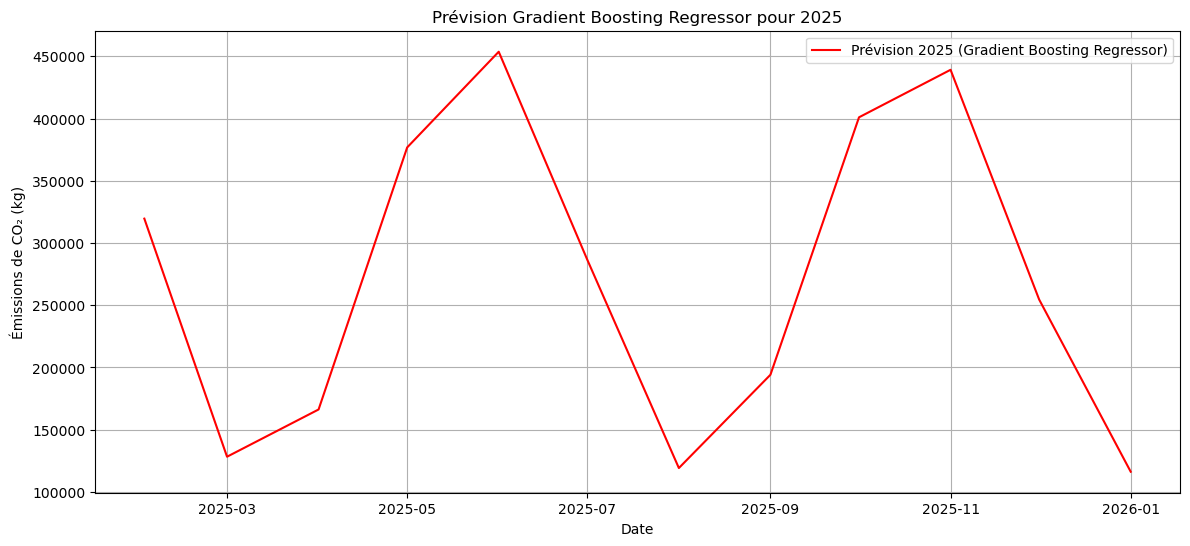

In [114]:

# 6️⃣ 🎨 Affichage Graphique
plt.figure(figsize=(14, 6))

plt.plot(forecast_series.index, forecast_series, label="Prévision 2025 (Gradient Boosting Regressor)", color='red')
plt.title("Prévision Gradient Boosting Regressor pour 2025")
plt.xlabel("Date")
plt.ylabel("Émissions de CO₂ (kg)")
plt.grid(True)
plt.legend()
plt.show()

# **Conclusion and Comparison between models**

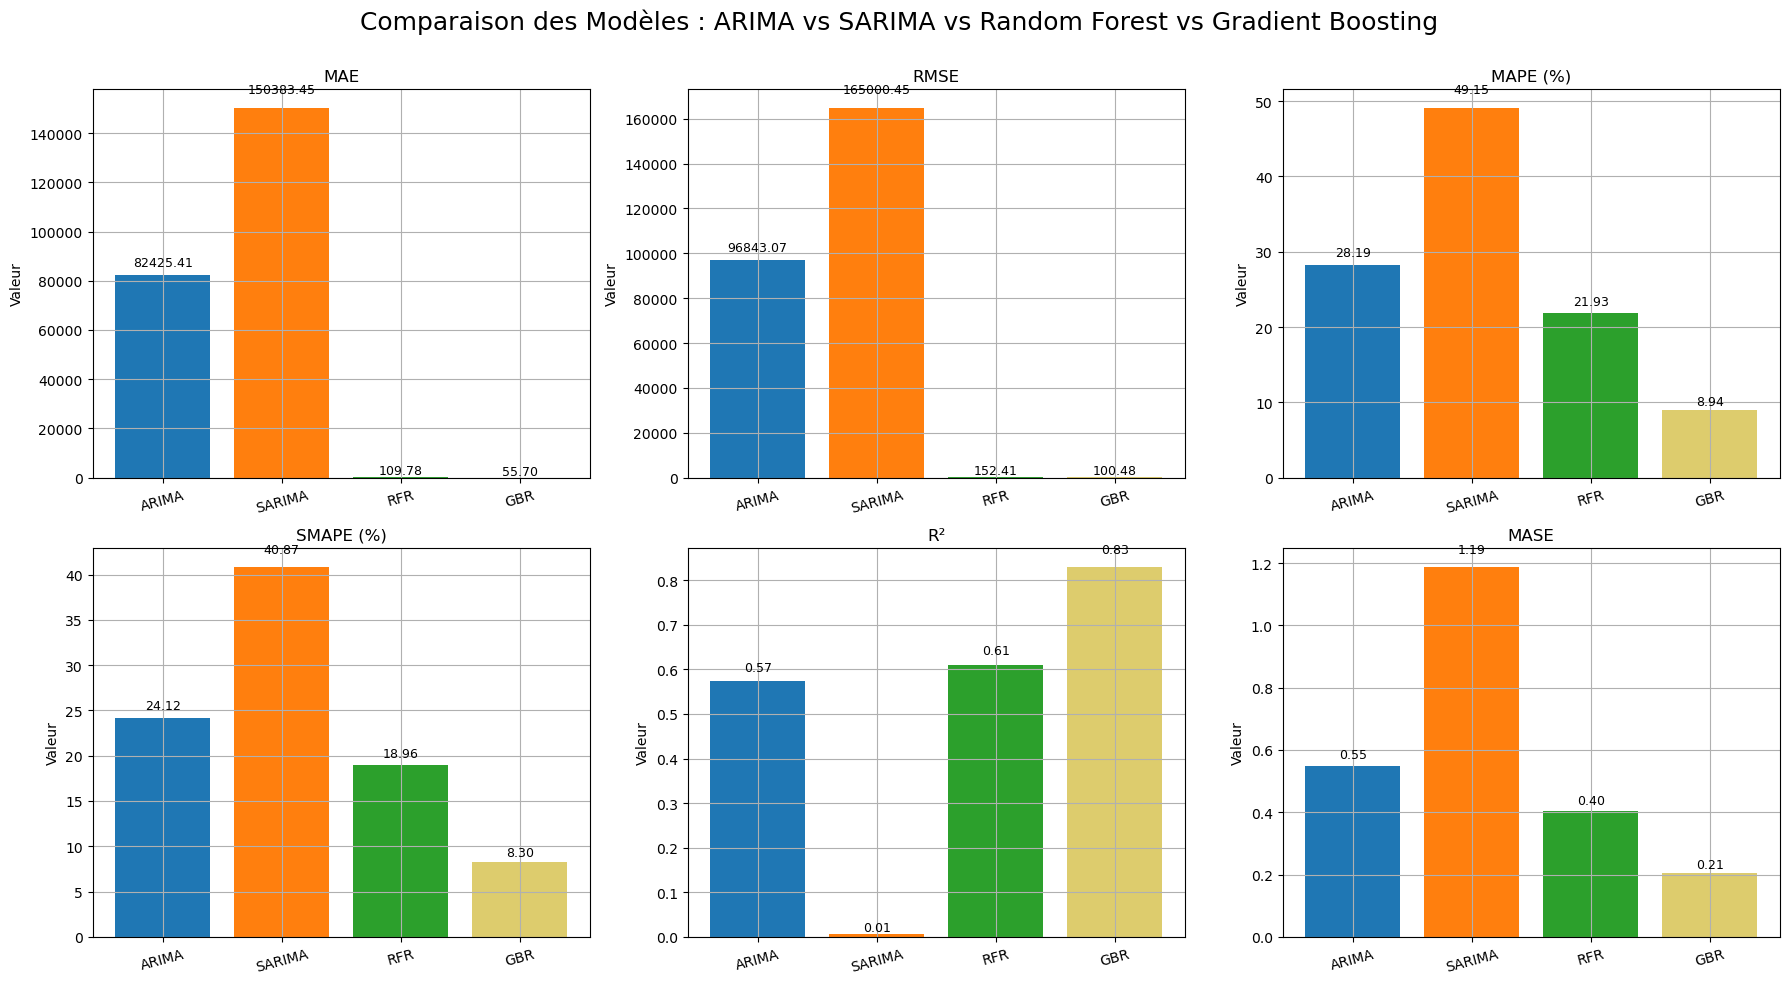

In [336]:
import matplotlib.pyplot as plt
import pandas as pd

# 📊 Données complètes des métriques
results = {
    "ARIMA":  [82425.41, 96843.07, 28.19, 24.12, 0.5734, 0.5482],   # MAE, RMSE, MAPE, SMAPE, R², MASE
    "SARIMA": [150383.45, 165000.45, 49.15, 40.87, 0.0054, 1.1887],
    "RFR":    [109.78, 152.41, 21.93, 18.96, 0.6096, 0.4048],
    "GBR":    [55.70, 100.48, 8.94, 8.30, 0.8303, 0.2054]
}


# 🧱 Créer le DataFrame
df_scores = pd.DataFrame(
    results, 
    index=["MAE", "RMSE", "MAPE (%)", "SMAPE (%)", "R²", "MASE"]
).T

# 📈 Création des barplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 lignes, 3 colonnes pour 6 métriques

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#ddcc6d"]

for i, metric in enumerate(df_scores.columns):
    row = i // 3
    col = i % 3
    bars = axes[row, col].bar(df_scores.index, df_scores[metric], color=colors)
    axes[row, col].set_title(metric)
    axes[row, col].set_ylabel("Valeur")
    axes[row, col].tick_params(axis='x', rotation=15)
    axes[row, col].grid(True)

    # ✏️ Ajouter les valeurs au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, height + abs(height)*0.03,
                            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle(" Comparaison des Modèles : ARIMA vs SARIMA vs Random Forest vs Gradient Boosting", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


 # Conclusion Final ! 

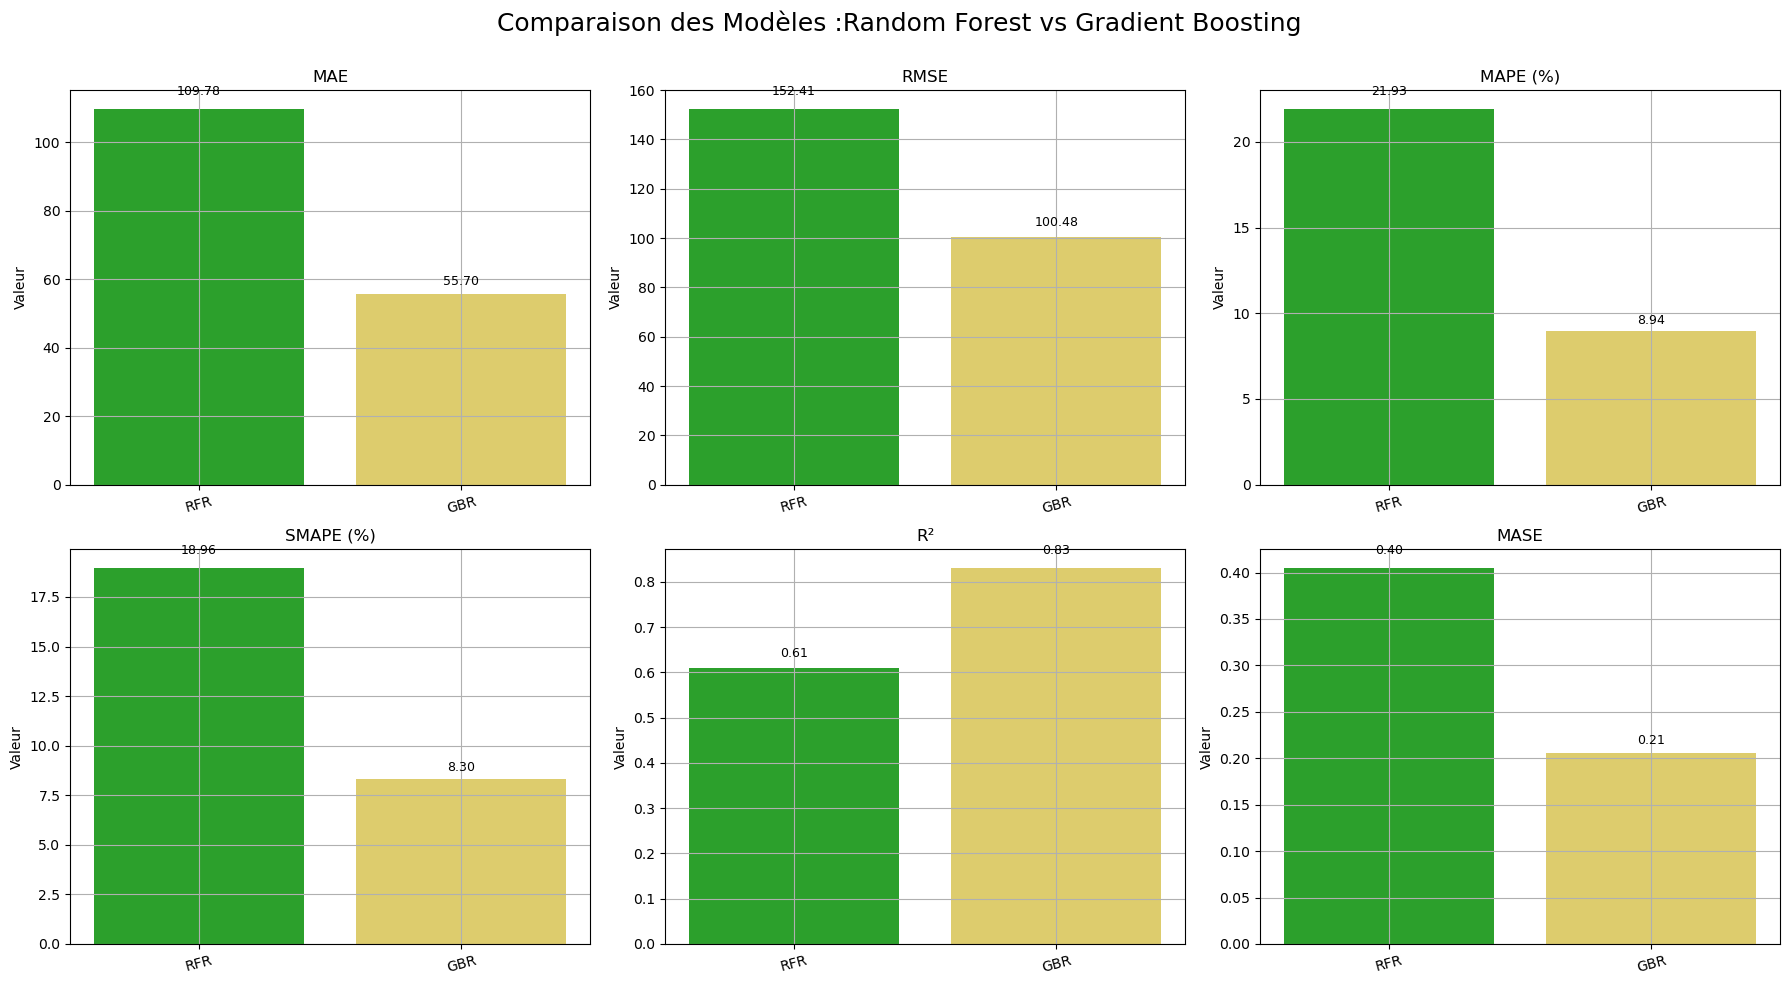

In [339]:
import matplotlib.pyplot as plt
import pandas as pd

# 📊 Données complètes des métriques
results = {

    "RFR":    [109.78, 152.41, 21.93, 18.96, 0.6096, 0.4048],
    "GBR":    [55.70, 100.48, 8.94, 8.30, 0.8303, 0.2054]
}


# 🧱 Créer le DataFrame
df_scores = pd.DataFrame(
    results, 
    index=["MAE", "RMSE", "MAPE (%)", "SMAPE (%)", "R²", "MASE"]
).T

# 📈 Création des barplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 lignes, 3 colonnes pour 6 métriques

colors = ["#2ca02c", "#ddcc6d"]

for i, metric in enumerate(df_scores.columns):
    row = i // 3
    col = i % 3
    bars = axes[row, col].bar(df_scores.index, df_scores[metric], color=colors)
    axes[row, col].set_title(metric)
    axes[row, col].set_ylabel("Valeur")
    axes[row, col].tick_params(axis='x', rotation=15)
    axes[row, col].grid(True)

    # ✏️ Ajouter les valeurs au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, height + abs(height)*0.03,
                            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle(" Comparaison des Modèles :Random Forest vs Gradient Boosting", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 📊 Description of Model Results: Random Forest vs. Gradient Boosting

The bar plots show a comparison between the performance of the **Random Forest Regressor (RFR)** and **Gradient Boosting Regressor (GBR)** models in terms of six key metrics: MAE, RMSE, MAPE, SMAPE, R², and MASE.

### 📈 Conclusion
- **Gradient Boosting Regressor (GBR)** outperforms **Random Forest Regressor (RFR)** in terms of overall accuracy, low errors, and ability to explain data variance.
- **Random Forest Regressor (RFR)** is robust and more efficient than **GBR** compared to a naive model, making it a good choice in scenarios where simplicity and relative performance are important.